## Lab 2: Amanda Chang
### LAB PREP

In [ ]:
# initialize
Vg = 18
V = 8
Pout = 12
Fs = 50e3 # 50kHz
Ts = 1/Fs
D = 0.35
C = 60

In [2]:
M = V/Vg
R = V**2/Pout
L = ((R*Ts*(1-M))/2)*(D/M)**2
Lcrit = (1-M)*R*(Ts/2)

k = 2*L/(Ts*R)
alpha = L/Lcrit
Ipk = ((k*(1-M))**0.5)*Ts*V/L
print(f"L={L}, k={k}, alpha={alpha}, Ipk={Ipk}")

L=1.8375e-05, k=0.34453125, alpha=0.62015625, Ipk=3.8095238095238106


$L = \left(\frac{R T_s (1 - M)}{2}\right)\left(\frac{D}{M}\right)^2$


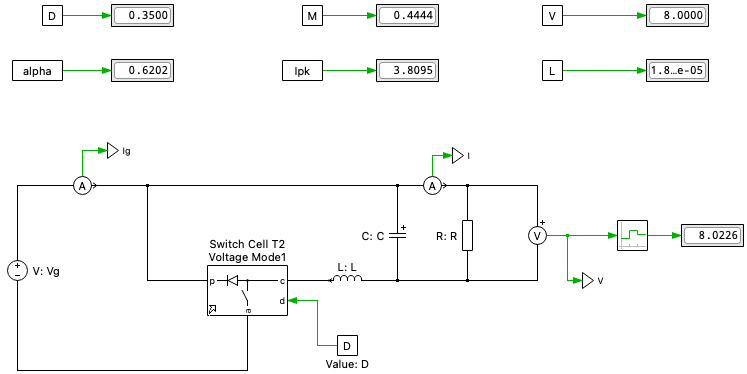

In [3]:
D = 0.5 # New Duty Cycle
from sympy import symbols, solve, Eq
m = symbols('M')
eq = Eq(L, (R*Ts*(1 - m)/2) * (D/m)**2)
sol = solve(eq, m)
print(f"The output voltage of the circuit with a {D} duty cycle is ~{sol[1]*Vg:.3f}V")

The output voltage of the circuit with a 0.5 duty cycle is ~10.135V


### TASK 1
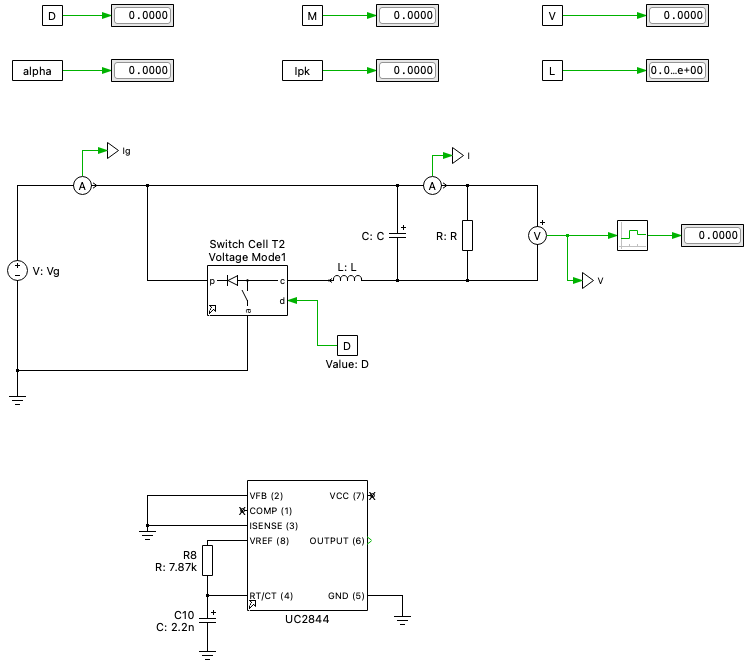

#### Q1: Calculate the switching frequency according to the RC values and equation provided in the UC2844 datasheet.

In [4]:
f_osc = 1.72/(7.87e3*2.2e-9)
print(f"The calculated switching frequency is {f_osc/2}")

The calculated switching frequency is 49670.786646644345


#### Q2: Attach a PLECS scope to pin 6 (OUTPUT) of the UC2844, run a simulation, and measure the actual switching frequency (fs). Confirm the correctness of what you see (how good is the match?).
The simulated switching frequency is ~48.5116kHz, which is a reasonable match to the calculated value of ~49.6708kHz.

#### Q3: What percentage is the duty cycle, and why is it at that particular value?	
The duty cycle is at 50% because the VREF never trips the comparator to reset the PWM latch since it isn't connected to power. This means that the PWM latch has no effect on the OUTPUT and it is instead driven entirely by the periodic changes in T, which is a signal switched on and off by the oscillation frequency. It then follows that T will be at half the oscillation frequency, giving us the duty cycle of 50% (which is the maximum this chip can output).

#### Replace the line "fs = ..." in the PLECS init script with the measured switching frequency.	
#### Q4: Copy your PLECS schematic and initialization script into your lab notebook. Save you model so that it can be submitted with the report.
##### PLECS Schematic
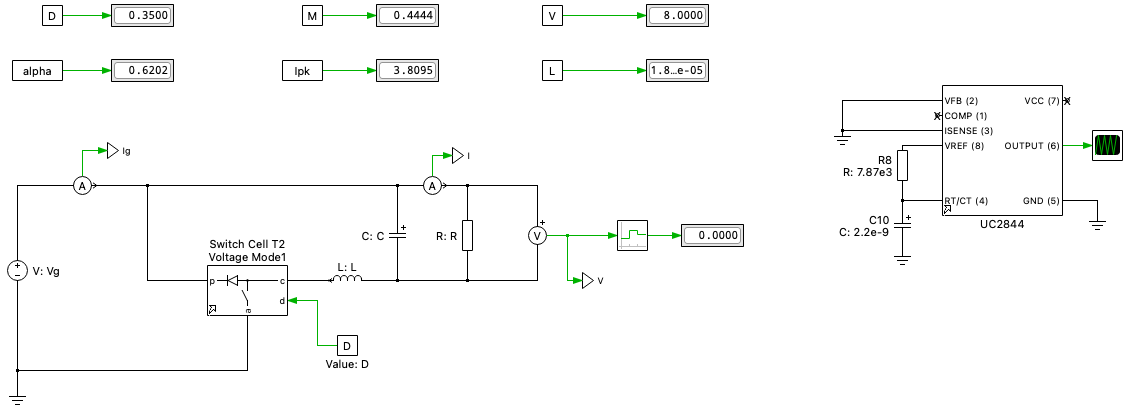

### TASK 2
#### Q5: Connect pin 6 (OUTPUT) to the gate of the MOSFET. Run the simulation and measure the average output voltage. Does it match your calculation from the lab prep? If not, revisit your calculations.
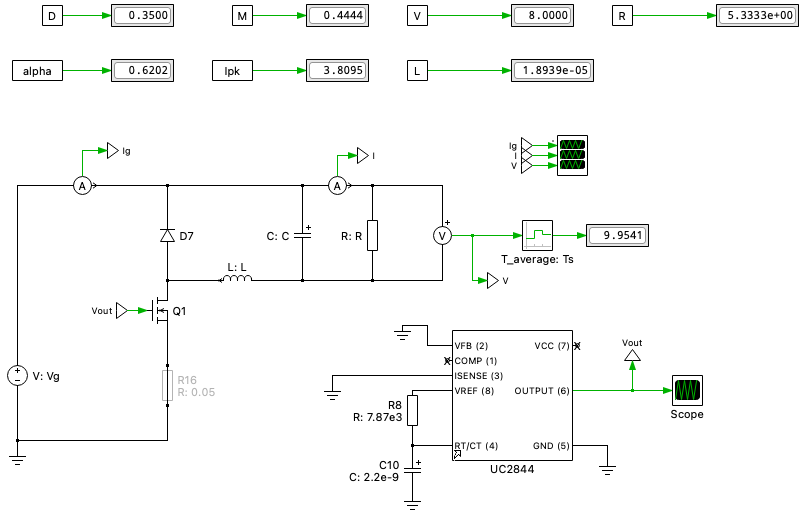

The average output voltage is approximately 9.9541V, which is very close to my calculated value of ~10.135V. The difference can likely be explained by the slightly different switching frequency.

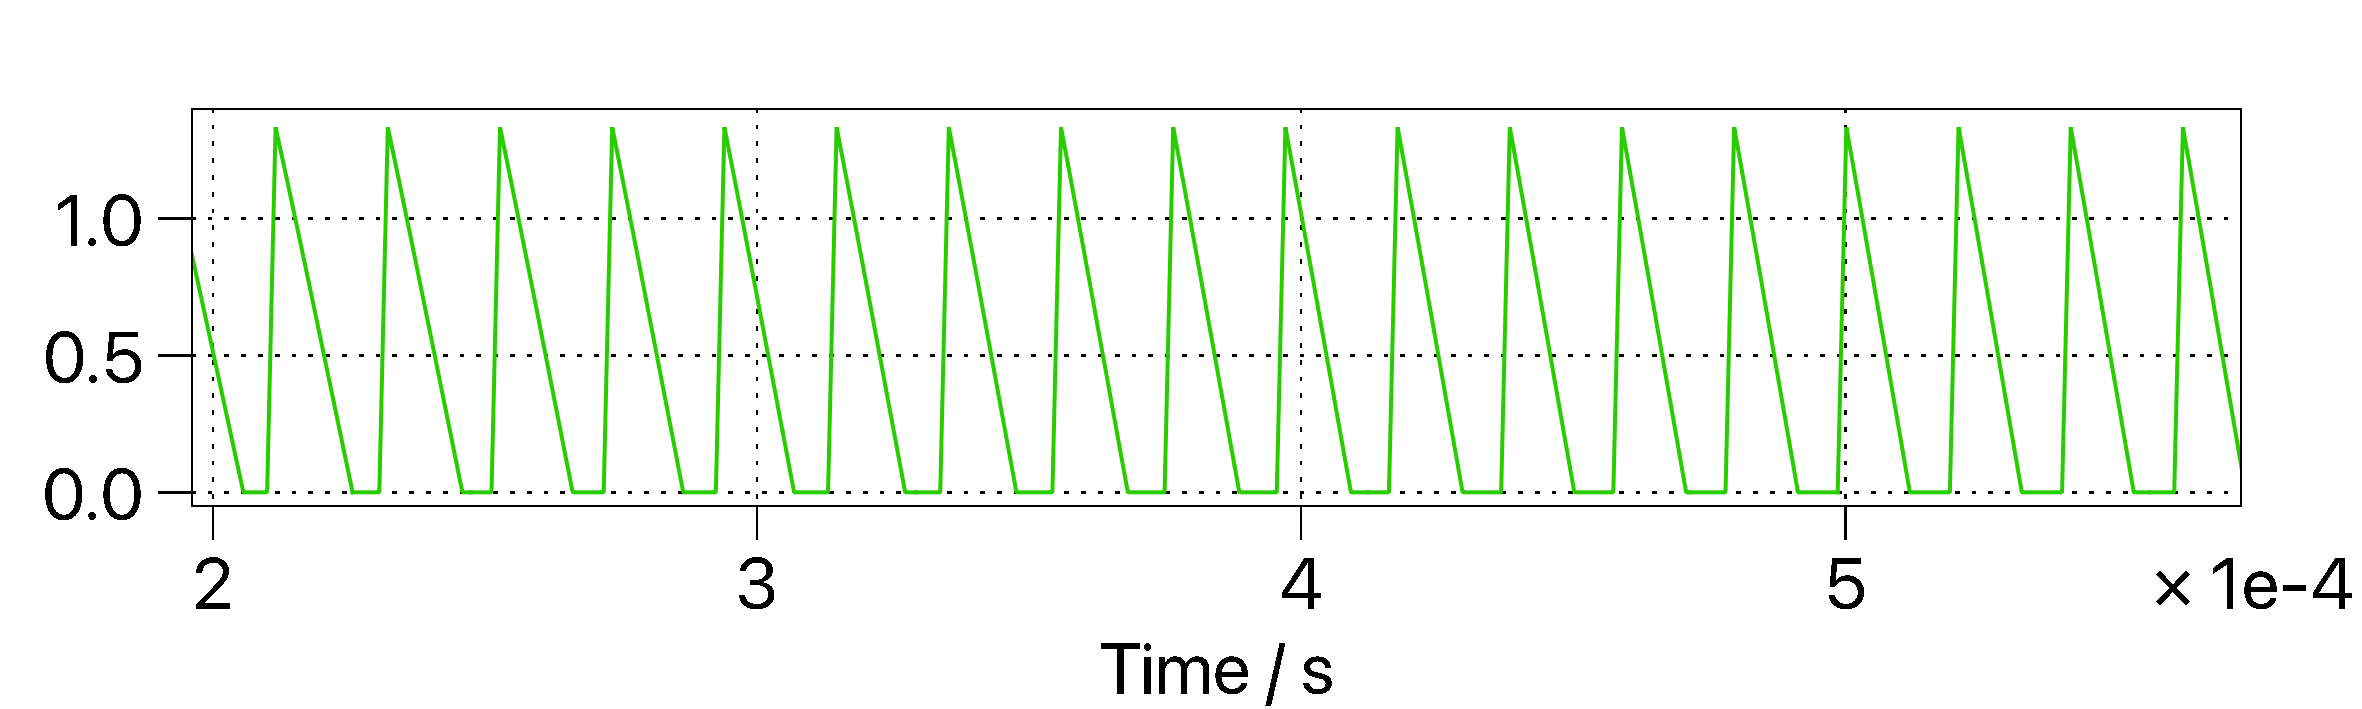

The peak current value with a reference voltage of 1.5V is ~1.33A.

#### Q6: Vary the voltage source from 1.5V to 1.8 in 0.1V increments and determine the peak current value for each setting.

- COMP Voltage Source (V): 1.5, 1.6, 1.7, 1.8
- Ipk values (A): 1.33, 2.00, 2.67, 3.33

#### Q7: Establish an expression for the peak of inductor current (Ipk) as a function of the voltage applied to the COMP pin (Vcomp). How does the expression relate to the components shown in Fig 12 of the UC2844 datasheet? 

$3I_{pk} = 20V_{comp} - 26$

To understand the relationship between peak current and the voltage applied to the COMP pin, we can trace through the schematic shown in Figure 12 of the UC2844 datasheet. $V_{comp}$ is dropped across two diodes, each with a forward voltage of $0.65V$ in the subsheet, to get us $V_{comp}-0.65*2$ at the start of the 2R-R resistor divider. The output of this divider $\frac{V_{comp}-0.65*2}{3}$ (which I will call $V_{div}$) is fed into the comparator. The comparator will reset the switch when the voltage at the Isense pin meets the voltage output of the divider on the other lead, meaning that the voltage through the shunt resistor at Isense is maximally $V_{div}$. With our shunt resistor value of $0.05\Omega$, we can manually calculate the maximum current $I_{pk}$ to be $\frac{V_{div}}{R_{sh}}$ or $\frac{V_{comp}-0.65*2}{3*0.05}$. With a bit of algebra, we can simplify it down to the equation I wrote above.

#### Q8: Solve this equation for Vcomp = f(Ipk), implement it in the PLECS model initialization script, and configure the initialization script to achieve the peak current value calculated in the lab prep that realizes an output of V=8V. Run the simulation and confirm the correctness of the output voltage, peak current and duty cycle.

$V_{comp} = \frac{3I_{pk} + 26}{20}$
The simulation output voltage, peak current, and duty cycle values are extremely close to the values I calculated/set, which were 8V, 3.80952, and 35%.

In [ ]:
V_out = 7.9926  # Average V_out at steady state
Ipk = 3.80952 # Peak Inductor Current
D = 7.223643930928322e-06/2.0612846971695617e-05 # Duty Cycle: T_on/Period 

print("SIMULATED VALUES")
print(
    f"Average Steady State Output Voltage: {V_out}\n" +
    f"Peak Inductor Current: {Ipk}A\n" +
    f"Duty Cycle: {D*100}%"
    )

0.7122447803083745
SIMULATED VALUES
Average Steady State Output Voltage: 7.9926
Peak Inductor Current: 0.7122447803083745A
Duty Cycle: 35.04437761968261%


#### Q9: Plot and comment thoroughly on the following waveforms:

- A. Source current Ig
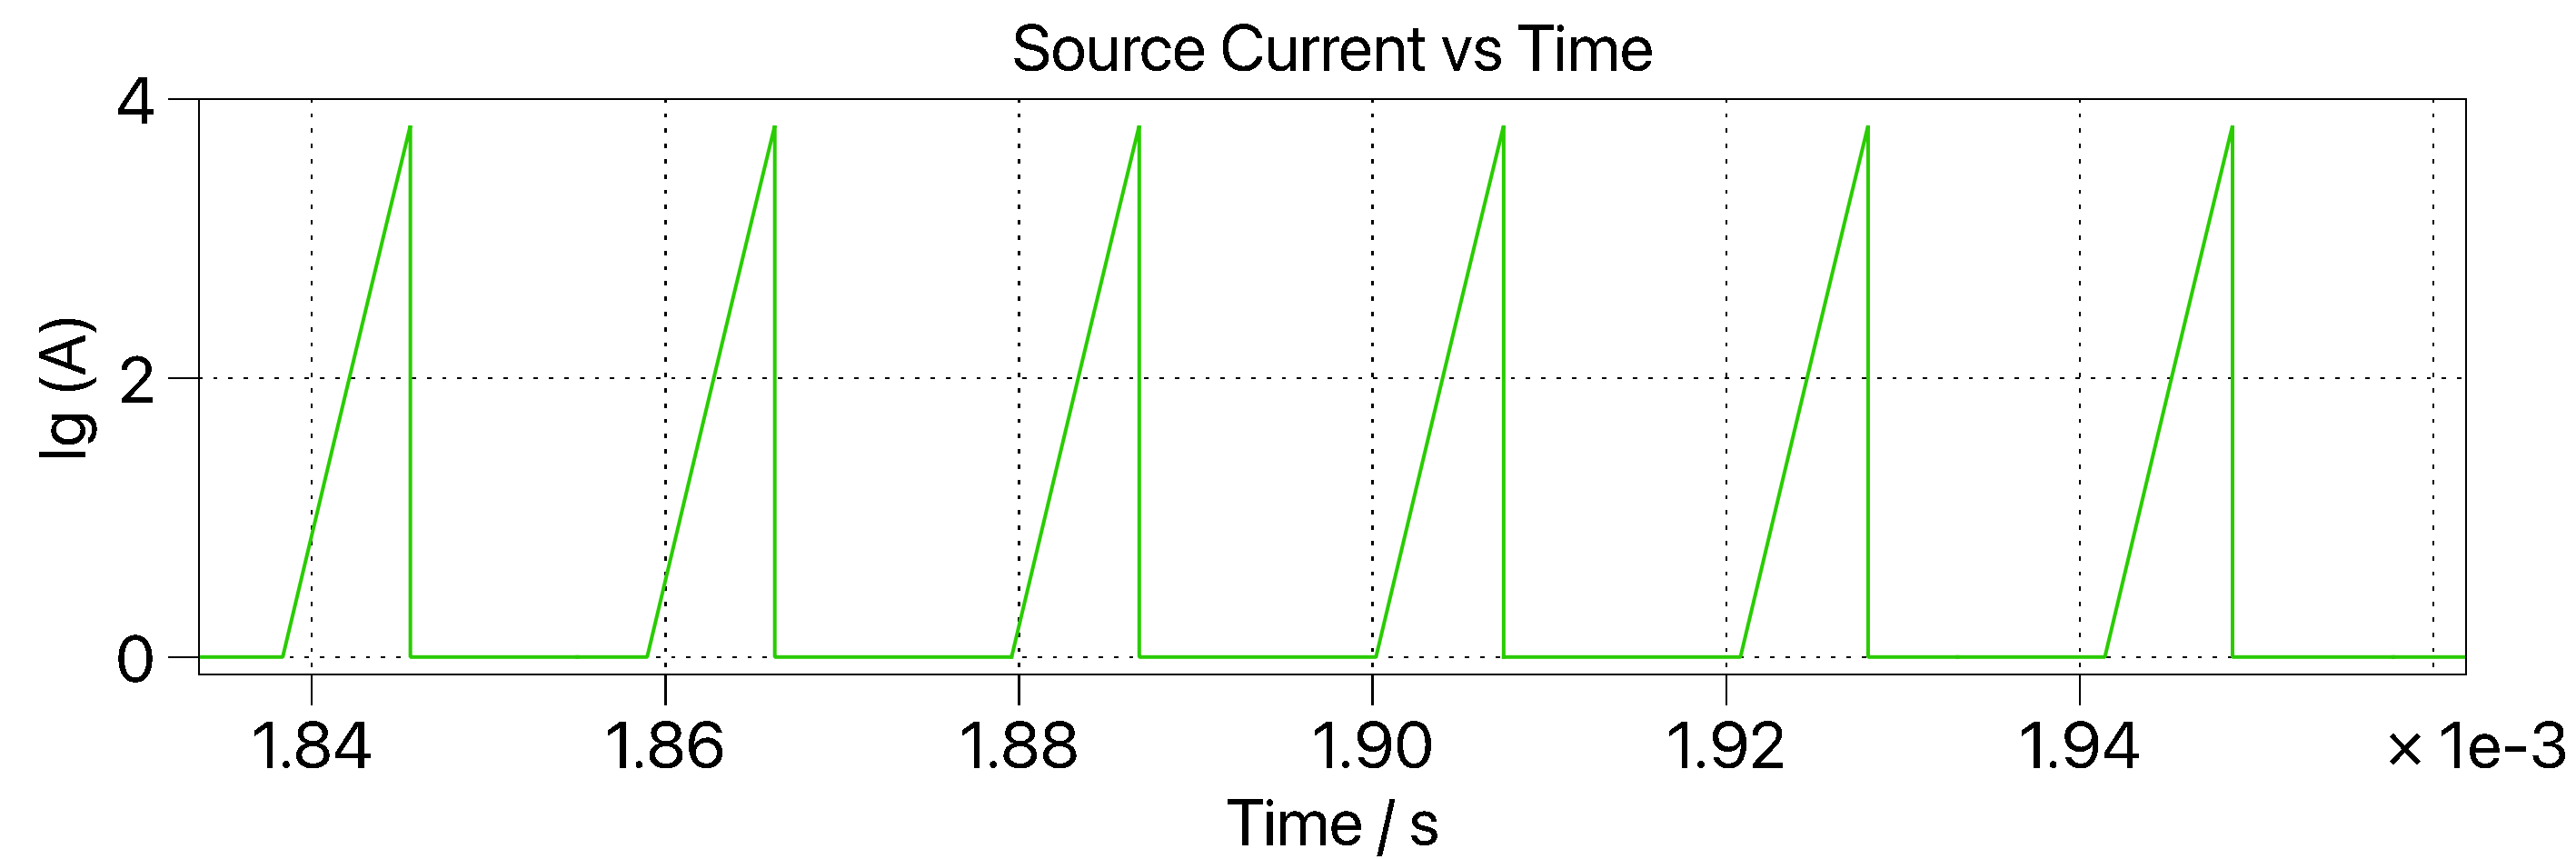

The source current increases linearly until hitting 3.8095A, which is the same number of amps as the peak inductor current. Upon reaching the maximum, the current drops down to 0 because UC844 shuts off Q1 once it reads that peak current in the form of Vsh. 

- B. Shunt voltage Vsh
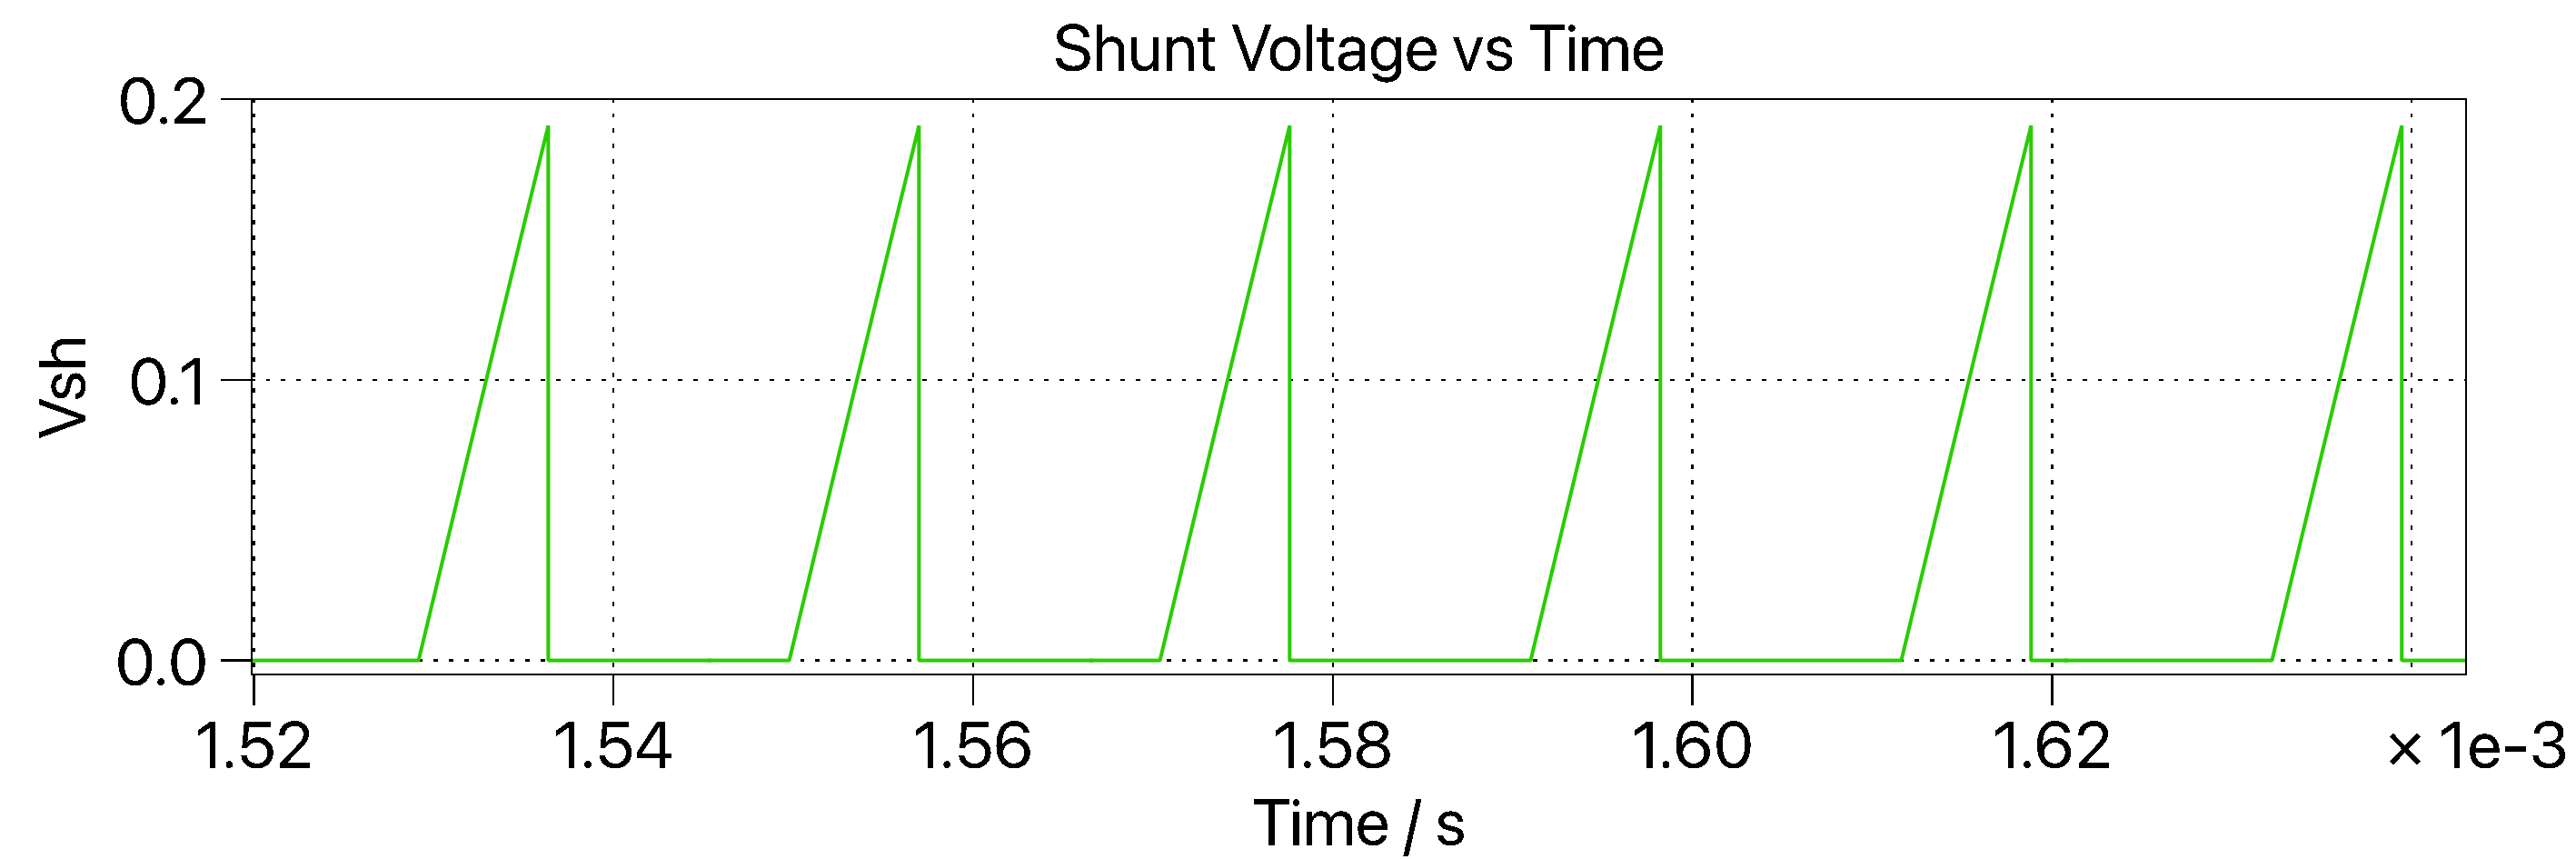

It follows that the shunt voltage follows the same pattern as source current, since all of the the source current flows through Rsh when Q1 is closed. It has the same right angle shape as the source current, reaching ~0.19V which corresponds to that 3.8095A Ipk previously calculated and validated in simulation.

- C. FET drain voltage Vd (connection point between diode and FET to GND). How many voltage levels do you observe? How do they correspond to the circuit and the states of Q and D?
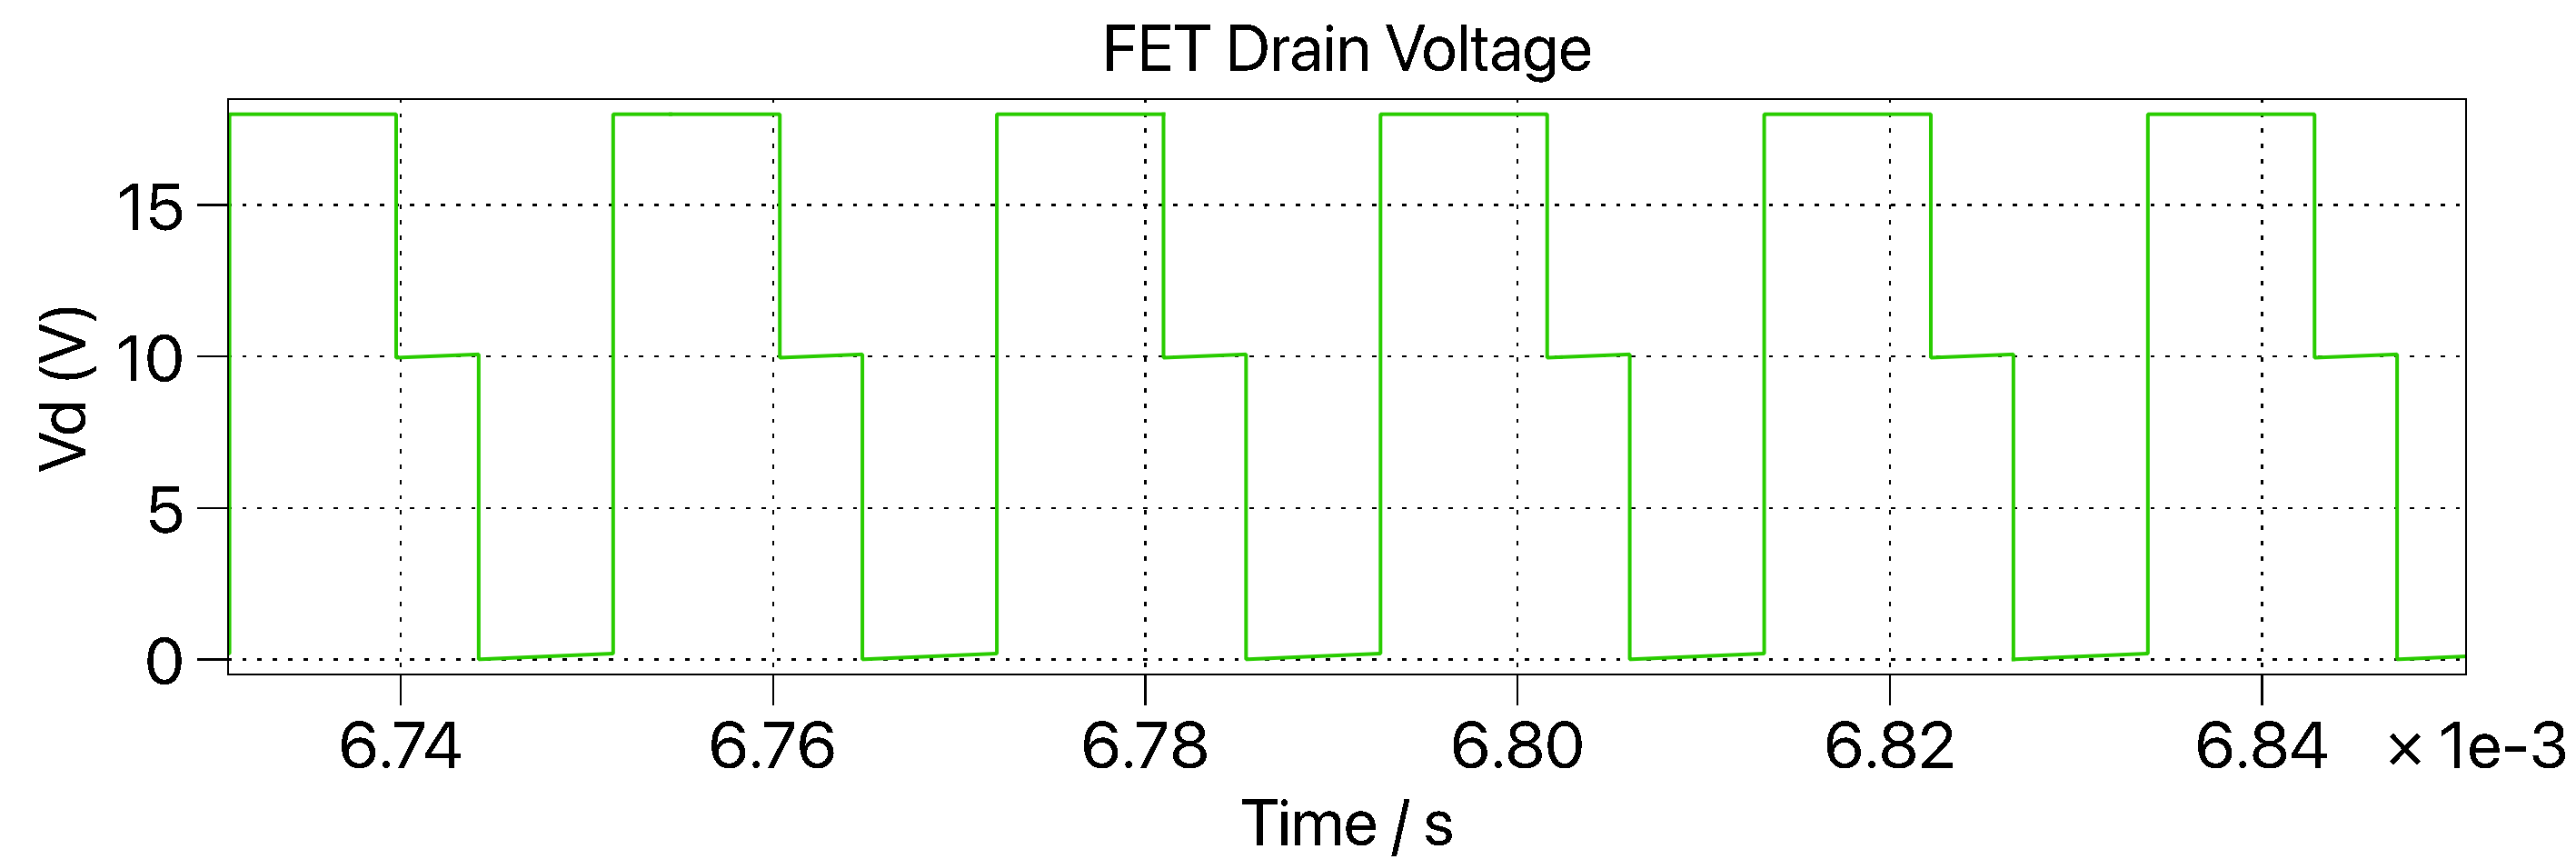

There are three voltage levels: 18V, 10V, and 0V. The voltage is at 18V when D is conducting and Q is open, at 10V when D is blocking and Q is open, and at 0V when Q is conducting.

- D. Inductor current
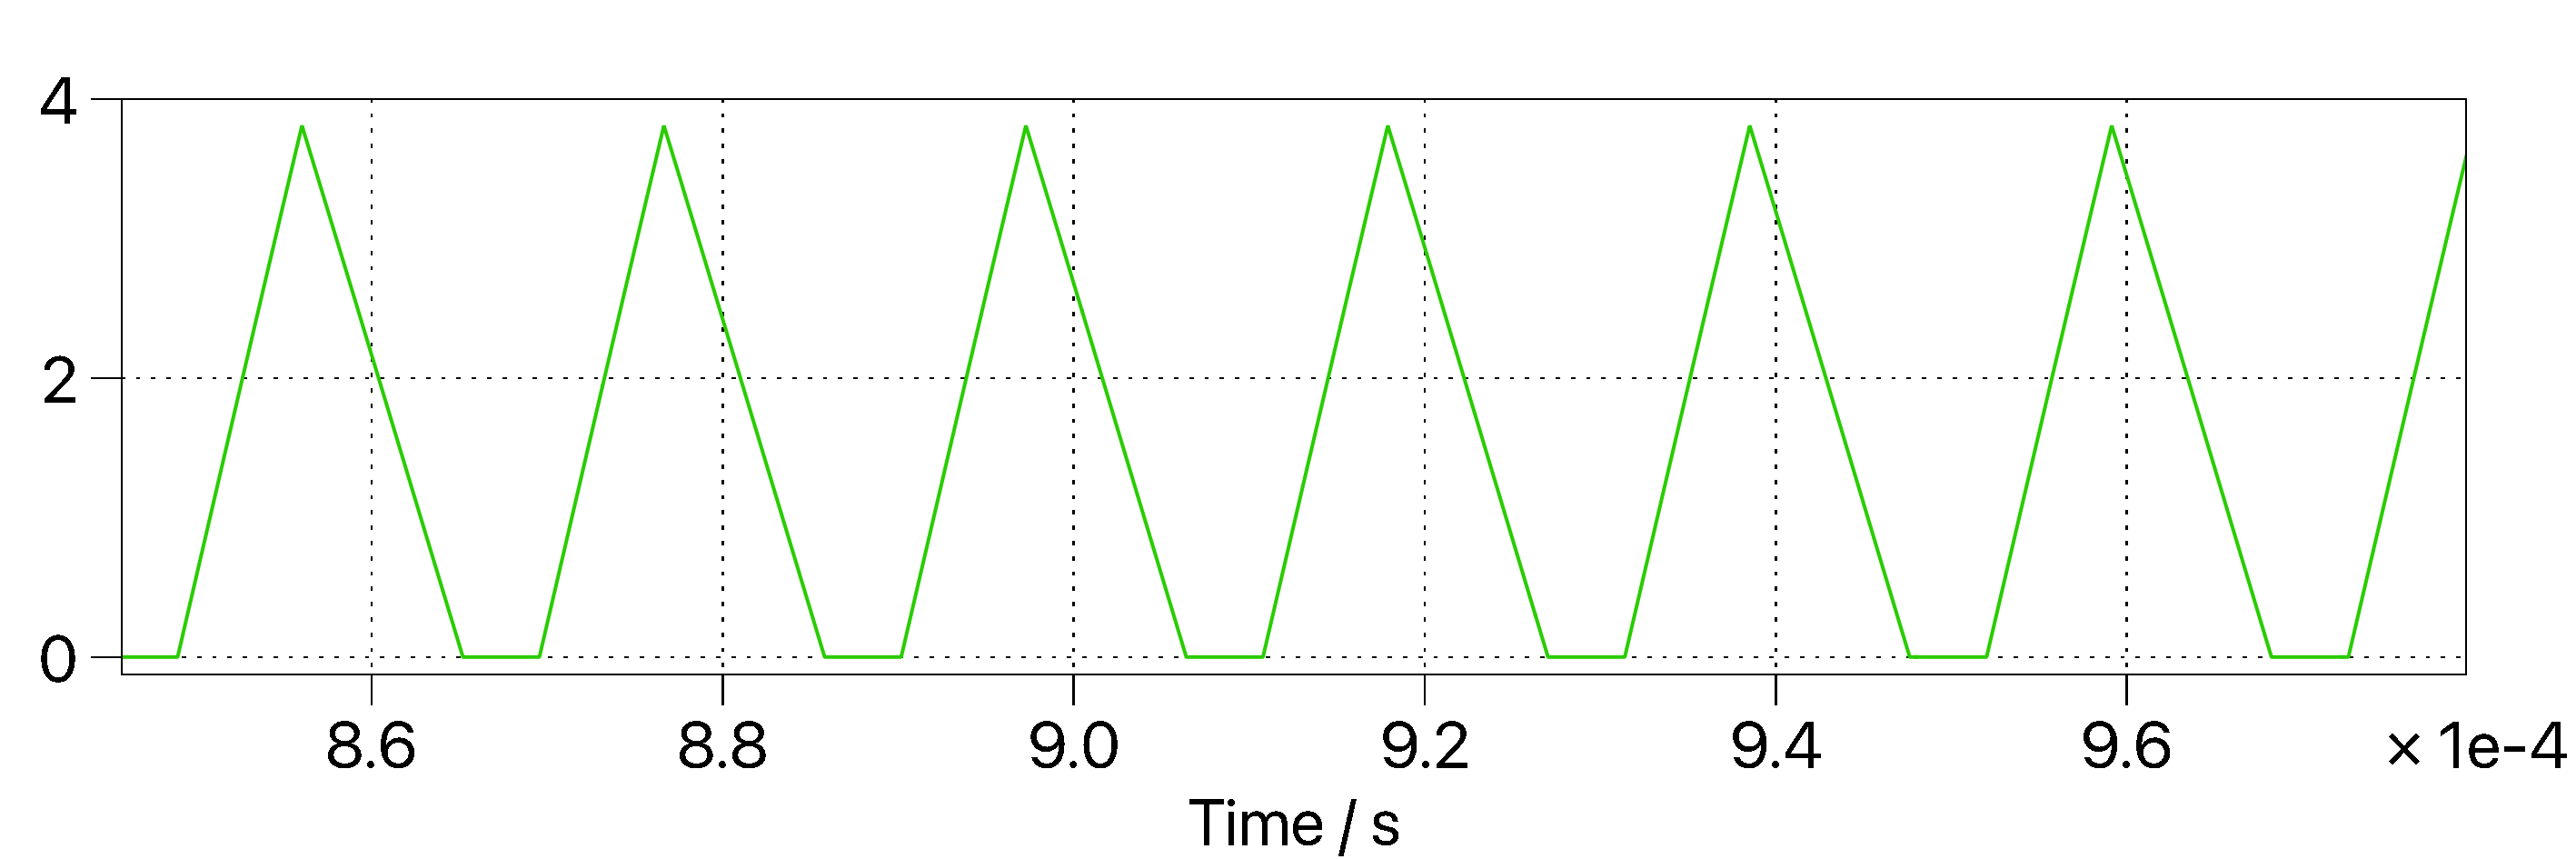

At steady state, the inductor current also reaches the same maximum as the source current, which makes sense since the source current flows through the inductor while it's charging up. However, the waveform differs from the source current here in that once the transistor Q1 shuts off at 3.8095A, the current begins to gradually drop instead of shutting off nearly instantly. This makes sense, as the current through an inductor cannot change instantaneously since that would require near infinite voltage since V=L(dI/dt). We can also tell that the circuit is in DCM since the inductor current reaches zero and settles there briefly in every cycle.

- E & F: Output current & Output Voltage
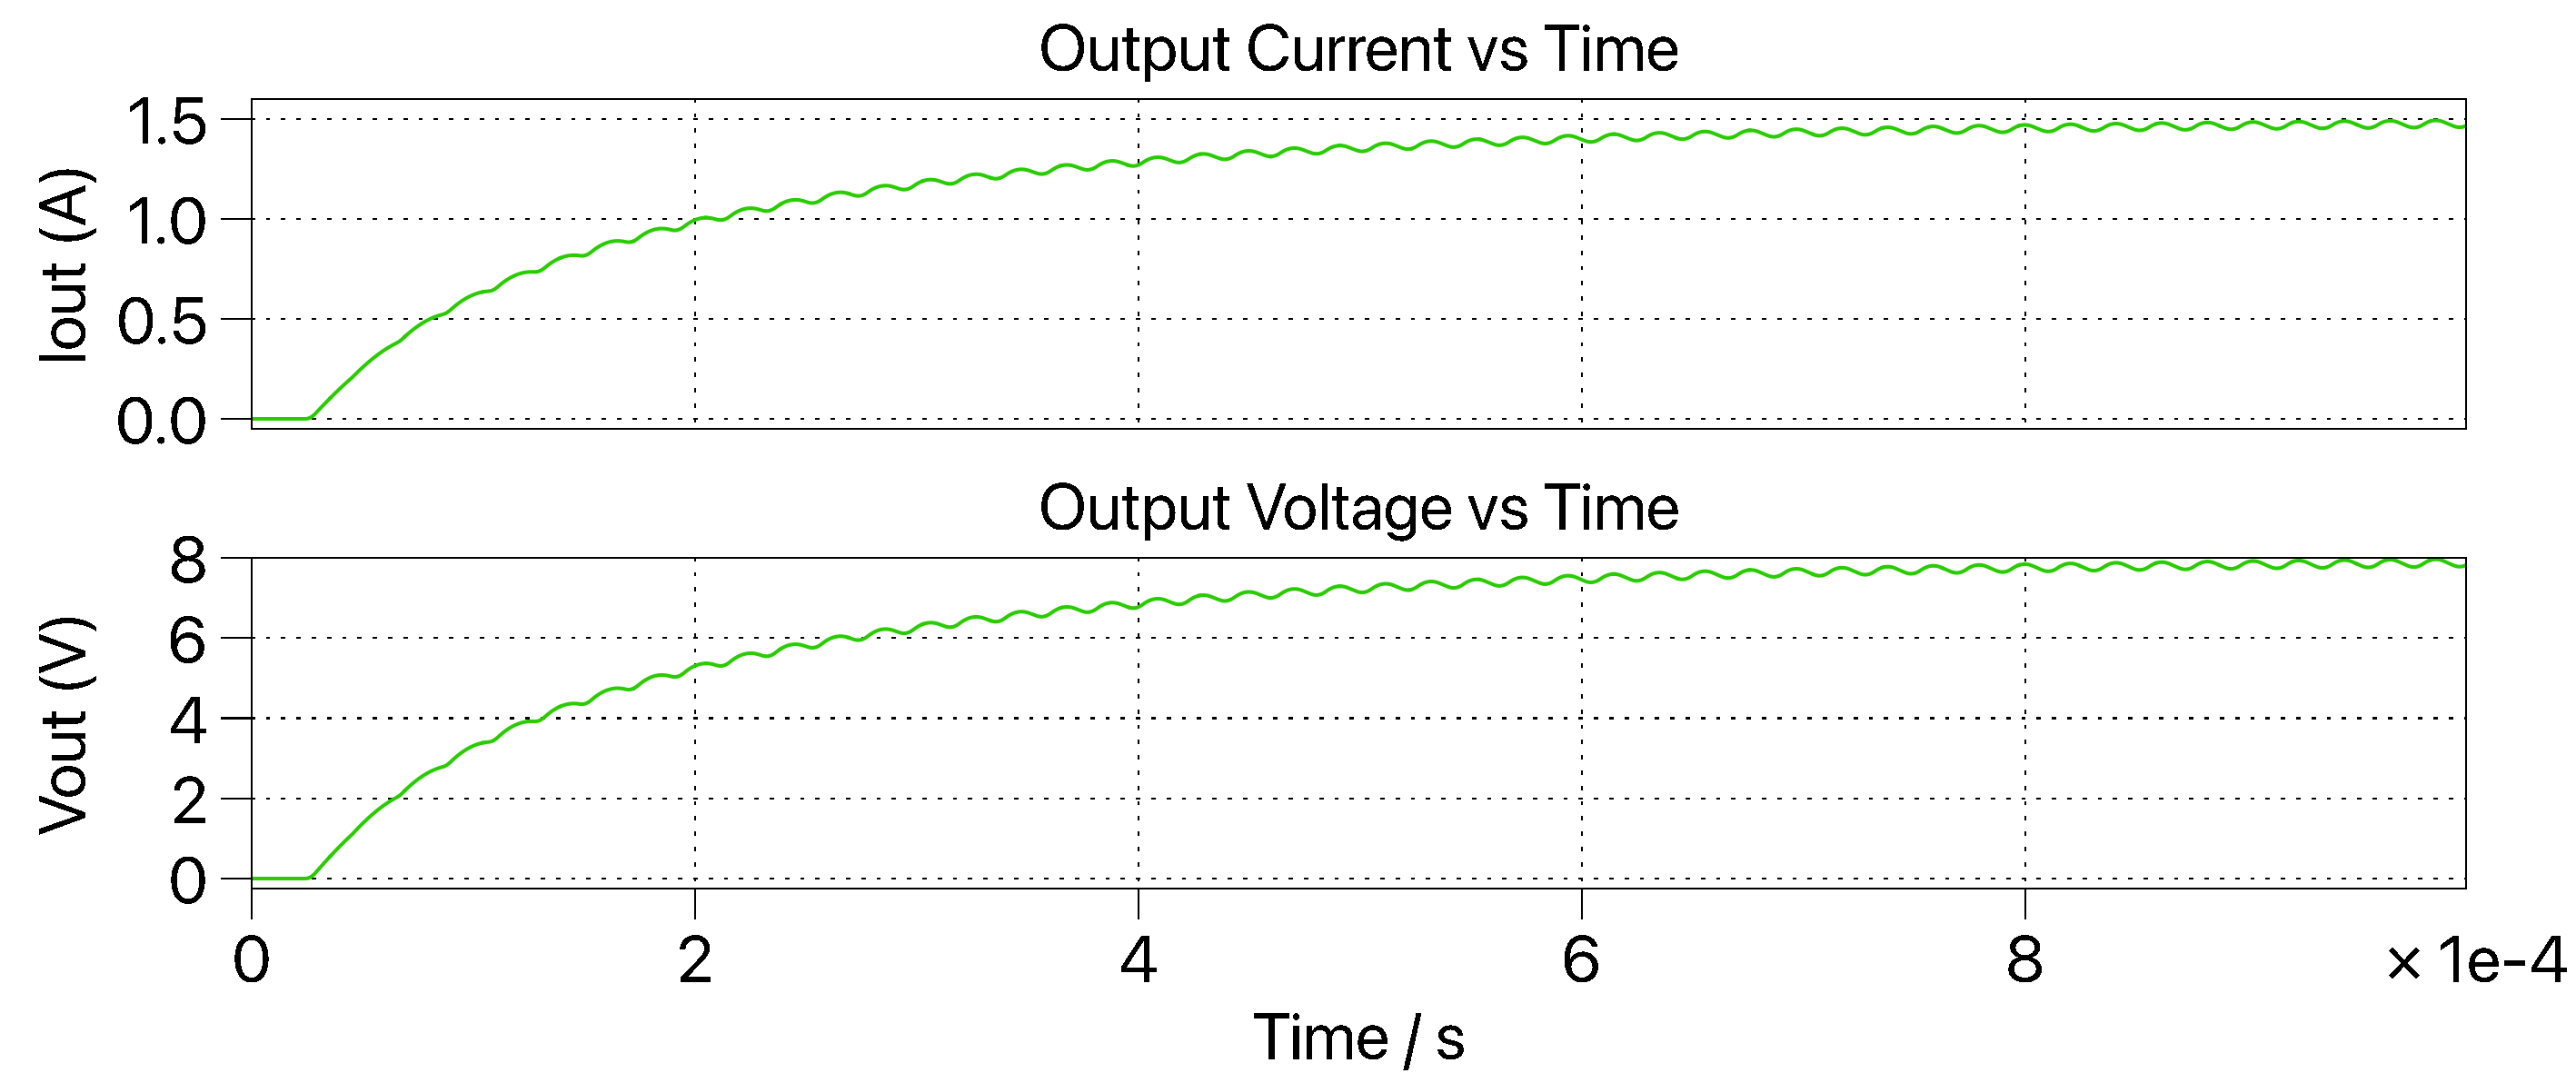

The output voltage is approximately 8V at steady state, and the output current is approximately 1.5A. The switching frequency also matches that of the FET.

#### Q10: Copy your PLECS schematic and initialization script into your lab notebook. Save you model so that it can be submitted with the report.

PLECS Schematic:



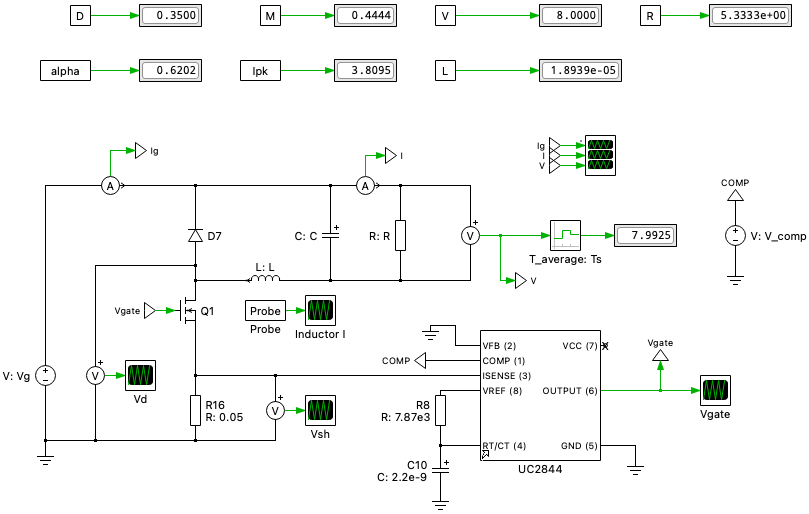

### TASK 3

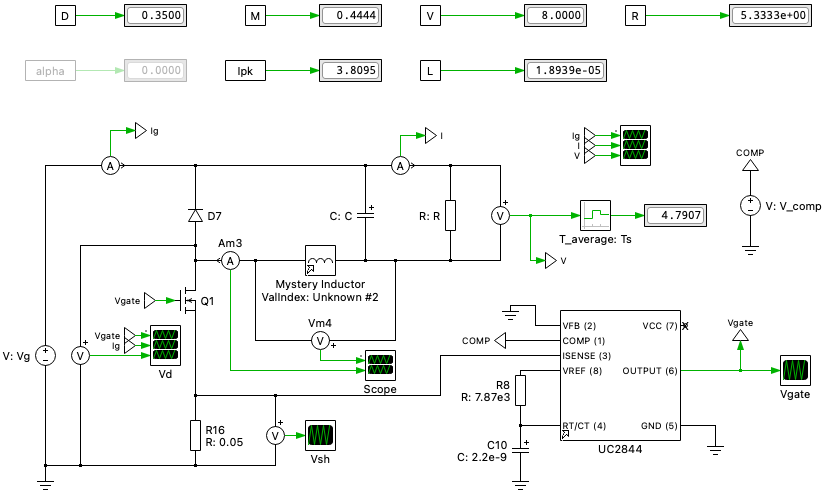

#### Q11: Document your "Unknown #N" selection
#### Run the simulation and use the voltage and current measurements to determine the unknown inductance value.
#### Figure out two different means to calculate inductance from measurements.
I have Unknown #2.

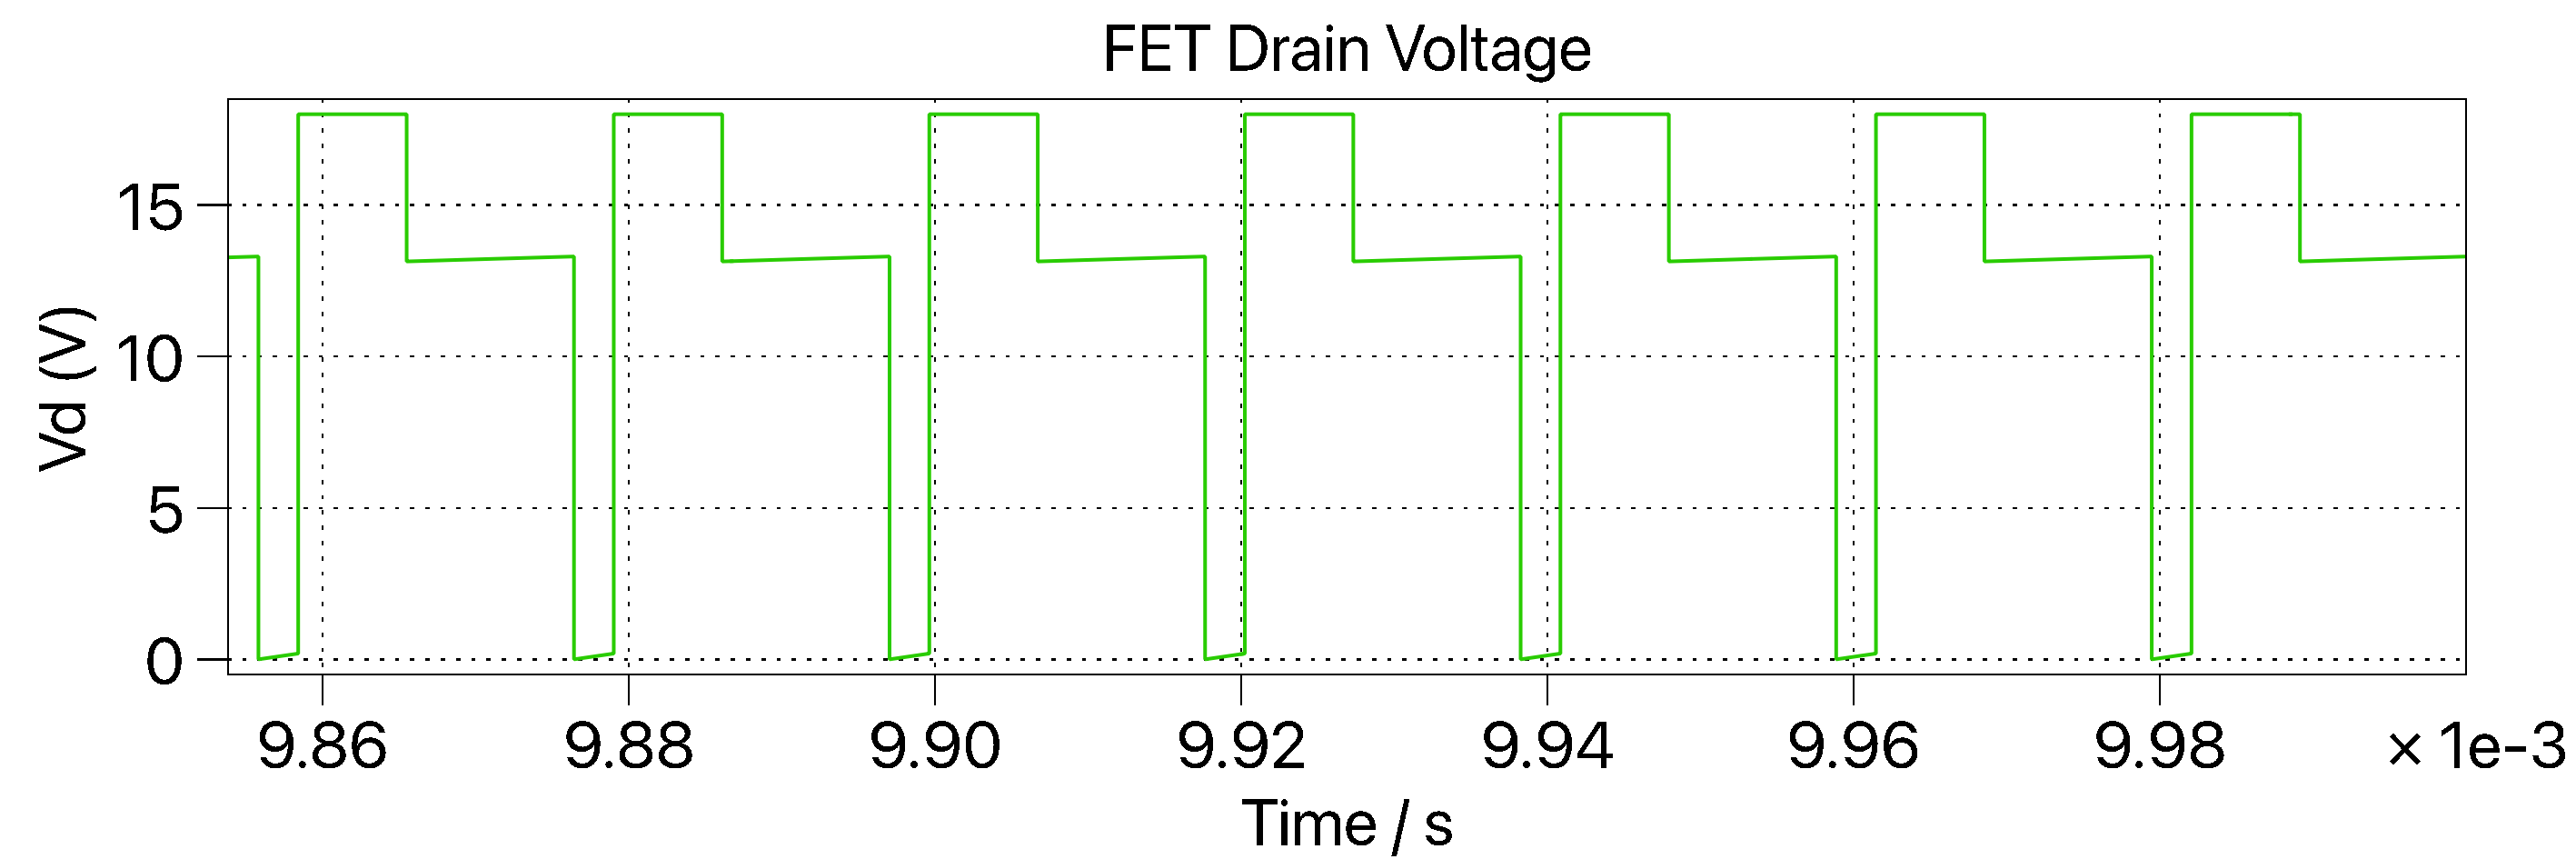

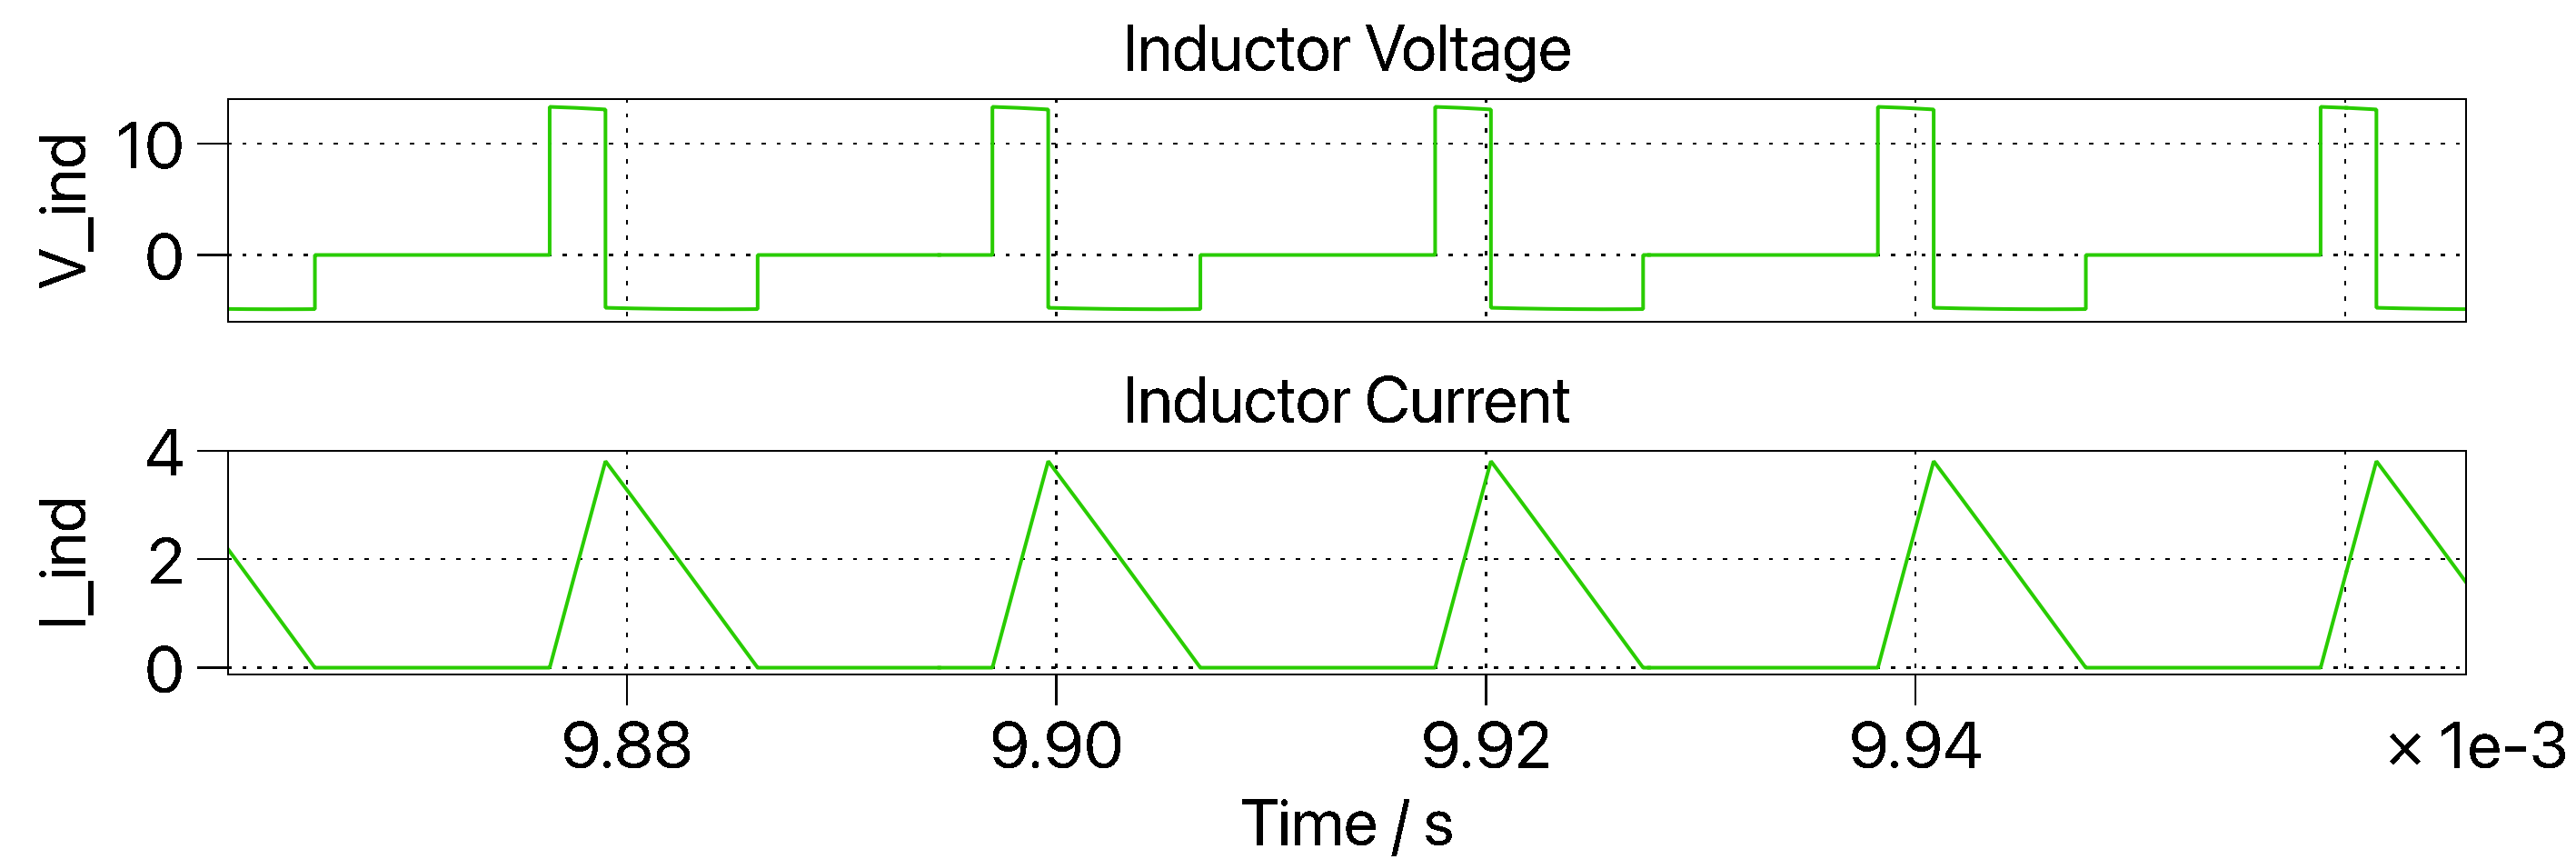

#### Q12: What is the value of the unknown inductance?

In [21]:
# V = L*(dI/dt)
V = 13.1952 # average value of the inductor highest voltage level
di_dt = 1.46654e06 # slope of the rising edge (corresponds to the highest voltage level)
print(f"The value of the unknown inductance is V/(dI/dt) or approximately {(V/di_dt)*1e6:.3f}uH")

The value of the unknown inductance is V/(dI/dt) or approximately 8.998uH


In [28]:
# initialize
Vg = 18
V = 4.7907
Pout = 12
Fs = 50e3 #50kHz
Ts = 1/Fs
Ipk = 3.80952
D = 0.35
C = 60
M = V/Vg
R = 5.33
Lcrit = (1-M)*R*(Ts/2)
alpha = ((2*V)/(R*Ipk))**2
L = alpha*Lcrit

print(f"The value of the unknown inductance using the characteristic equation for inductance comes out to approximately {L*1e6:.3f}uH")

The value of the unknown inductance using the characteristic equation for inductance comes out to approximately 8.710uH


#### Q13: Provide the equations used to determine inductance.

Method 1:

$L = V_{ind}*(\frac{dI}{dt})^{-1}$

Method 2:

$\alpha = \left(\frac{2V}{R\,I_{\text{pk}}}\right)^2$

$L_{\text{crit}} = (1 - M)\,R\,\left(\frac{T_s}{2}\right)$

$L = \alpha\,L_{\text{crit}}$